In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn

import aug_functions

import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble='''
        \\usepackage[utf8]{inputenc}
        \\usepackage{amssymb}
        \\usepackage{amsfonts}
        \\usepackage[russian]{babel}''')

In [3]:
good_objects_df = pd.read_csv("../data/plasticc/good_objects.csv", index_col=0)
good_objects_df.sample(10)

,object_id,mjd,passband,flux,flux_err,detected,log_lam,class
4094897,130894,60184.3777,3,39.150387,2.516344,1,3.875155,0
9753124,308590,60608.1460,3,50.236275,1.172034,1,3.875155,0
2842994,91035,60651.1265,2,57.765789,0.874582,1,3.790512,1
304797,158042,60532.2696,3,34.186775,1.230722,1,3.875155,1
621337,309772,59902.0916,2,152.856308,1.348299,1,3.790512,1
55296,29416,60499.2579,0,34.482712,2.622438,1,3.574189,1
624927,310925,60415.0127,3,29.400743,1.345684,1,3.875155,0
5982073,189473,60003.2386,1,10.755261,1.077366,1,3.675929,0
4922990,156667,60621.2673,2,17.468704,0.958009,1,3.790512,1
8374335,265044,60567.3838,1,37.674370,0.862888,1,3.675929,0


In [4]:
good_object_ids = np.unique(good_objects_df.object_id)

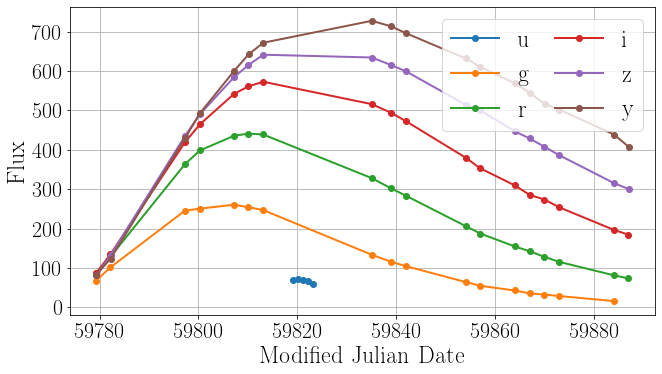

In [5]:
anobject = aug_functions.get_object(good_objects_df, 34299)

aug_functions.plot_light_curves(anobject)

In [6]:
augmentation_model = "NN_single"

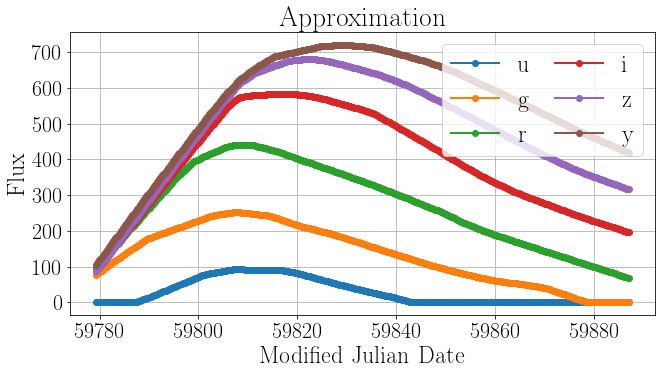

In [7]:
from sklearn.model_selection import train_test_split

anobject = aug_functions.get_object(good_objects_df, 34299)
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

# fit augmentation model
model = None
if augmentation_model == "GP":
    import gp_aug
    model = gp_aug.GaussianProcessesAugmentation(aug_functions.passband2lam)
elif augmentation_model == "NN_single":
    import single_layer_regressor
    model = single_layer_regressor.SingleLayerNetAugmentation(aug_functions.passband2lam)
elif augmentation_model == "FE":
    import features_aug
    model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
else:
    raise ValueError("Unknown augmentation type: {}".format(augmentation_model))
    
# fit augmentation model
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

# augmentation
t_aug, flux_aug, flux_err, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                              anobject['mjd'].max(), 
                                                              n_obs=aug_functions.N_OBS)
anobject_test_pred = aug_functions.compile_obj(anobject_test['mjd'].values, 
                                               flux_pred, anobject_test['passband'].values)
anobject_aug = aug_functions.compile_obj(t_aug, flux_aug, passbands_aug)
aug_functions.plot_light_curves(anobject_aug, "Approximation")

In [8]:
from tqdm import tqdm_notebook

all_data = []
all_target_classes = []
for good_id in tqdm_notebook(good_object_ids):
    anobject = aug_functions.get_object(good_objects_df, good_id)
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

    # initialize augmentation model
    model = None
    if augmentation_model == "GP":
        model = gp_aug.GaussianProcessesAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "NN_single":
        model = single_layer_regressor.SingleLayerNetAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "FE":
        model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
    else:
        raise ValueError("Unknown augmentation type")

    # fit augmentation model
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, 
                                             anobject_test['passband'].values, copy=True)

    # augmentation
    t_aug, flux_aug, flux_err, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), 
                                                                  n_obs=aug_functions.N_OBS)

    data_array = flux_aug.reshape((aug_functions.N_PASSBANDS, aug_functions.N_OBS)).T
    all_data.append([data_array])
    
    true_class = int(anobject['class'].to_numpy()[0])
    all_target_classes.append(true_class)
    
all_data = np.array(all_data)
all_target_classes = np.array(all_target_classes)
print(all_data.shape, all_target_classes.shape)


(2508, 1, 500, 6) (2508,)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

device = 'cpu'

In [10]:
X_train, X_test, y_train, y_test = train_test_split(all_data, 
                                                    all_target_classes,
                                                    test_size=0.4,
                                                    random_state=179)

# normalize input
X_train_norm = np.array((X_train - X_train.mean()) / X_train.std(), dtype=np.float32)
X_test_norm = np.array((X_test - X_train.mean()) / X_train.std(), dtype=np.float32)

X_train_tensor = torch.from_numpy(X_train_norm)
y_train_tensor = torch.from_numpy(np.array(y_train, dtype=np.float32))

train_data = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1,
                                          shuffle=True, num_workers=2)

X_test_tensor = torch.from_numpy(X_test_norm)
y_test_tensor = torch.from_numpy(np.array(y_test, dtype=np.float32))

test_data = TensorDataset(X_test_tensor, y_test_tensor)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,
                                         shuffle=False, num_workers=2)

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(10, 2))
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(10, 2))
        self.conv3 = nn.Conv1d(8, 16, kernel_size=(5, 2))
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(3824, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = x.view(-1, 3824)
        
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [20]:
import torch.optim as optim

net = Net()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [21]:
def get_model_accuracy(net, data_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for test_info in data_loader:
            images, test_labels = test_info
            test_outputs = net(images)
            prob = test_outputs.item()
            if prob > 0.5:
                predicted = 1
            else:
                predicted = 0
            total += test_labels.size(0)
            correct += (predicted == test_labels.item())

    return correct / total

In [22]:
epochs = np.arange(100)
for epoch in tqdm_notebook(epochs):  # loop over the dataset multiple times
    epoch_loss = 0.0
    for info in trainloader:
        # get the inputs; info is a list of [inputs, labels]
        inputs, labels = info

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # print mean loss for the epoch
    cur_loss = epoch_loss / X_train_norm.shape[0]
    if (epoch + 1) % 10 == 0:
        print('[%5d] error: %.3f' % (epoch + 1, cur_loss))

print('Finished Training')

[   10] error: 0.688
[   20] error: 0.687
[   30] error: 0.681
[   40] error: 0.392
[   50] error: 0.233
[   60] error: 0.658
[   70] error: 0.213
[   80] error: 0.190
[   90] error: 0.181
[  100] error: 0.161

Finished Training


In [36]:
test_accuracy = get_model_accuracy(net, testloader)
train_accuracy = get_model_accuracy(net, trainloader)

print('Test accuracy of the network on the %d test images: %.4f' % 
      (X_test_norm.shape[0], test_accuracy))
print('Train accuracy of the network on the %d train images: %.4f' % 
      (X_train_norm.shape[0], train_accuracy))

Test accuracy of the network on the 1004 test images: 0.9223
Train accuracy of the network on the 1504 train images: 0.9441


In [37]:
y_test = []
y_probs = []
y_probs_0 = []
y_probs_1 = []

with torch.no_grad():
    for test_info in testloader:
        images, test_labels = test_info
        test_outputs = net(images)
        prob = test_outputs.item()
            
        true_class = int(test_labels.item())
        if true_class == 0:
            y_probs_0.append(prob)
        else:
            y_probs_1.append(prob)

        y_test.append(true_class)
        y_probs.append(prob)

In [38]:
from sklearn.metrics import log_loss
y_pred = np.array(y_probs) > 0.5
print("LogLoss = %.4f" % log_loss(y_test, y_pred))

LogLoss = 2.7177


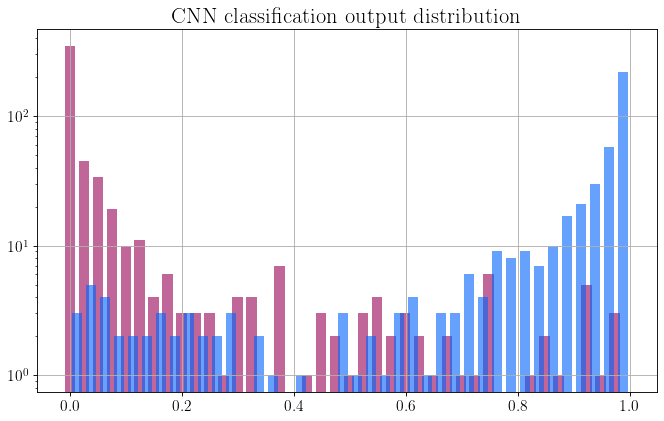

In [39]:
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("CNN classification output distribution", fontsize=20)
plt.xticks(fontsize=14, color="black")
plt.yticks(fontsize=14, color="black")
plt.grid(True)
plt.hist(y_probs_0, bins=40, color="xkcd:dark magenta", align="left", rwidth=0.75, alpha=0.6, log=True)
plt.hist(y_probs_1, bins=40, color="xkcd:bright blue", rwidth=0.75, alpha=0.6, log=True)
plt.show()
fig.savefig("../pictures/CNN_output_hist_{}.pdf".format(augmentation_model),
           bbox_inches='tight', pad_inches=0.01)

Test ROC-AUC: 0.9735, test PR-AUC: 0.9675


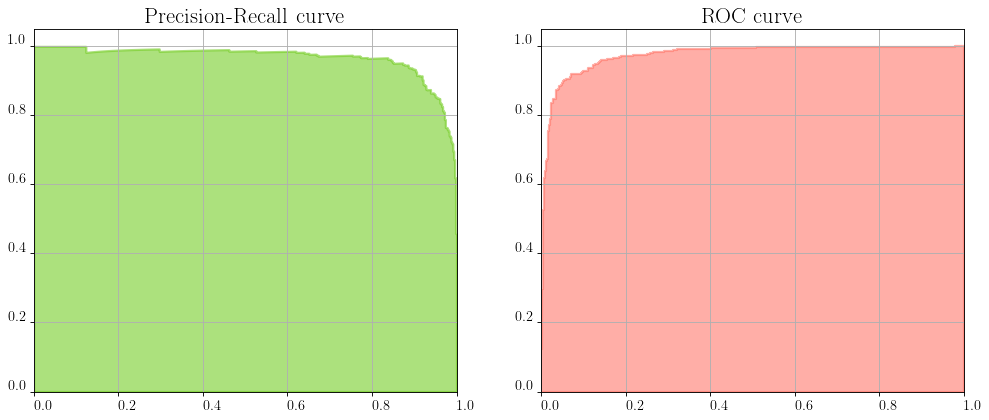

In [40]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

DPI = 80
SIZE_X, SIZE_Y = 15, 6

print("Test ROC-AUC: %.4f, test PR-AUC: %.4f" % (roc_auc_score(y_test, y_probs), 
                                                 average_precision_score(y_test, y_probs)))

precision, recall, _ = precision_recall_curve(y_test, y_probs)

fig = plt.figure(dpi=80, figsize=(15, 6))
ax = fig.add_subplot(121)
plt.grid(True)
plt.xticks(color="black", fontsize=13, ha="left")
plt.yticks(color="black", fontsize=13, va="bottom")
ax.set_title("Precision-Recall curve", fontsize=20, color="black")
ax.fill_between(recall, precision, alpha=0.6, color="xkcd:apple green", lw=2)
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.05)

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

ax = fig.add_subplot(122)
plt.grid(True)
plt.xticks(color="black", fontsize=13, ha="left")
plt.yticks(color="black", fontsize=13, va="bottom")
ax.set_title("ROC curve", fontsize=20, color="black")
ax.fill_between(fpr, tpr, alpha=0.6, color="xkcd:salmon", lw=2)
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.05)

fig.savefig("../pictures/CNN_pr_roc_curves_{}.pdf".format(augmentation_model), 
            bbox_inches='tight', pad_inches=0.01)

In [ ]:
# добавить тестирование на плохих объектах...

In [ ]:
assert 1 == 0

In [41]:
# metrics = [ROC-AUC, PR-AUC, Accuracy, LogLoss, Time]
GP_metrics = [0.9786, 0.9643, 0.9313, 2.0641, "08:51"]
NN_single_metrics = [0.9735, 0.9675, 0.9223, 2.7177, "40:46"]
FE_metrics = [0.9841, 0.9830, 0.9303, 2.4081, "50:34"]

ans_df = pd.DataFrame(columns=["AUC-ROC", "AUC-PR", "Accuracy", "LogLoss", "Time"],
                     index=["GP", "NN 1L", "FE"],
                     data=[GP_metrics, NN_single_metrics, FE_metrics])
ans_df

,AUC-ROC,AUC-PR,Accuracy,LogLoss,Time
GP,0.9786,0.9643,0.9313,2.0641,08:51
NN 1L,0.9735,0.9675,0.9223,2.7177,40:46
FE,0.9841,0.9830,0.9303,2.4081,50:34


In [ ]:
y_prob_all = []
y_test_all = []

In [ ]:
augmentation_model = "GP"

In [ ]:
meta_file_test = '../data/plasticc/plasticc_test_metadata.csv.gz'
metadata = pd.read_csv(meta_file_test)

for batch_number in range(1, 12):
    file = "../data/plasticc/PLAsTiCC-2018/test_set_batch{}.csv".format(batch_number)
    data = pd.read_csv(file)

    data = data[data.detected == 1]
    object_ids = np.unique(data.object_id)
    print(batch_number, object_ids.shape)
    
    data["log_lam"] = data.apply(lambda x: aug_functions.passband2lam[x.passband], axis=1)
    
    all_data = []
    all_target_classes = []

    for i in tqdm_notebook(object_ids):
        if i in good_object_ids:
            continue
        
        anobject = aug_functions.get_object(data, i)
        
        anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

        model = None
        if augmentation_model == "GP":
            model = gp_aug.GaussianProcessesAugmentation(aug_functions.passband2lam)
        elif augmentation_model == "NN_single":
            model = single_layer_regressor.SingleLayerNetAugmentation(aug_functions.passband2lam)
        else:
            raise ValueError("Unknown augmentation type")

        try:
            model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
                      anobject_train['flux_err'].values, anobject_train['passband'].values)
        except:
            continue

        flux_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

        t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                          anobject['mjd'].max(), 
                                                                          n_obs=aug_functions.N_OBS)

        data_array = flux_aug.reshape((aug_functions.N_PASSBANDS, aug_functions.N_OBS)).T
        all_data.append([data_array])
        true_class = 1 if int(metadata[metadata.object_id == i].true_target.to_numpy()[0]) in (90, 67, 52) else 0
        all_target_classes.append(true_class)

    all_data = np.array(all_data)
    all_target_classes = np.array(all_target_classes)
    print(batch_number, all_data.shape, all_target_classes.shape)
    
    X_test_batch_norm = np.array((all_data - X_train.mean()) / X_train.std(), dtype=np.float32)
    X_test_batch_tensor = torch.from_numpy(X_test_batch_norm)

    y_test_batch_tensor = torch.from_numpy(np.array(all_target_classes, dtype=np.float32))

    test_batch_data = TensorDataset(X_test_batch_tensor, y_test_batch_tensor)
    test_batch_loader = torch.utils.data.DataLoader(test_batch_data, batch_size=1, shuffle=True, num_workers=2)

    with torch.no_grad():
        for test_info in test_batch_loader:
            images, test_labels = test_info
            test_outputs = net(images)
            prob = test_outputs.item()
            
            y_prob_all.append(prob)
            y_test_all.append(test_labels.item())
            
    del data
    del object_ids
    del all_data
    del all_target_classes
    del X_test_batch_norm
    del X_test_batch_tensor
    del y_test_batch_tensor
    del test_batch_data
    del test_batch_loader